# yolov4 커스텀 모델 훈련하기



1. 데이터 수집
2. 모델생성
3. 트레인 및 실행

## Yolov4 Darknet 

### Step1 : GPU 활성화

* 수정> 노트설정> None --> GPU

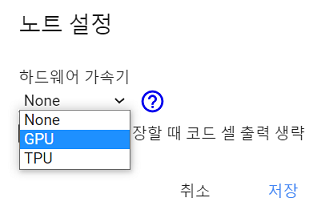

### Step2 : Cloning Darknet

In [ ]:
# git darknet 
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15035, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 15035 (delta 11), reused 18 (delta 8), pack-reused 15002
Receiving objects: 100% (15035/15035), 13.41 MiB | 23.80 MiB/s, done.
Resolving deltas: 100% (10209/10209), done.


In [ ]:
# Makefile 을 수정하여 설정 바꾸기
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# CUDA 버젼 확인
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# make Darknet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 심볼릭 링크 생성
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

 backup		    data       helpfunction.py	 ppt	       yolov4
'Colab Notebooks'   data.zip   MyDrive		 __pycache__


## 단계 1. 데이터 압축하기 & 구글 드라이브 업로드

1. train 디렉토리 안에 훈련용 데이터는 train.zip, valid 디렉토리 안에 검증용 데이터는 valid.zip

2. 구글 드라이브에 업로드 한다.




### 데이터 셋 클라우드(구글 드라이브로 옮기기)

In [ ]:
# 디렉토리 생성 
!mkdir /mydrive/yolov4/tutorial/backup -p

In [ ]:
!pwd

/content/darknet


In [ ]:
import gdown

In [ ]:
!gdown --id 1xMZgAe-JQ20GlHVMGH6clHyDjv1iZGUd --output train.zip
!gdown --id 1acC-CapIbCpKzUaIQfWDcZTebRKiPRfq --output valid.zip

Downloading...
From: https://drive.google.com/uc?id=1xMZgAe-JQ20GlHVMGH6clHyDjv1iZGUd
To: /content/darknet/train.zip
886MB [00:09, 89.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1acC-CapIbCpKzUaIQfWDcZTebRKiPRfq
To: /content/darknet/valid.zip
89.1MB [00:03, 23.3MB/s]


In [ ]:
# 직접 복사 하는 경우
# !cp /mydrive/yolov4/tutorial/train.zip ./
# !cp /mydrive/yolov4/tutorial/valid.zip ./

In [ ]:
!ls *.zip

train.zip  valid.zip


In [ ]:
!unzip ./train.zip -d data/
!unzip ./valid.zip -d data/

## 단계 2. 설정하기

* 모델 선택 : [Yolov4 github How to train](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)

### Cfg File

* batch = 64, subdivisions = 16
(문제가 생길시 32의 배수와 약수로 변경)


* 트레인 하는 classes 의 숫자에 따라서 결정 (현재는 Cat, Dog, Coffee cup 으로 3개 기준)

* 3개의 클래스 기준 : max_batches = 6000, steps = 4800, 5400 , filters = 24



1. width = 416, height = 416
(더 나은 결과를 608로 바꿀수 있지만 시간이 오래 걸린다.)
2. max_batches = **클래스 수** * 2000 (클래스가 3 이하일때는 6000) 

3. step = (max_batches의 80%), (max_batches의 90%)

4. yolo 층의 classes 를 바꾸어준다.

4. filters = (**클래스 수** + 5) * 3 (3개의 yolo 레이어 직전의 컨벌루션 층만 바꿔준다)

5. 메모리 이슈가 있을시에는 random = 1을 random = 0 으로 바꾸어준다. (정확도 손실이 소량 있을수 있다.)

In [ ]:
# 선택할 yolo 모델의 cfg를 복사합니다. 
# 한번 복사한 후에는 주석으로 막아주세요.
# !cp /content/darknet/cfg/yolov4-custom.cfg /mydrive/yolov4/tutorial/yolov4-tutorial.cfg 

yolov4-obj.cfg 를 수정한다. 


클래스 수 2개 

1. width = 416, height = 416
2. max_batches = 6000
3. step = 4800, 5400
4. classes=2 를 바꾸어준다.(3번)
5. filter = 21로 바꾸어준다.(3번)

filters = (클래스 수 + 5) * 3 (3개의 yolo 레이어 직전의 컨벌루션 층만 바꿔준다)

메모리 이슈가 있을시에는 random = 1을 random = 0 으로 바꾸어준다. (정확도가 손실이 소량 있을수 있다.)

In [ ]:
# 변경된 cfg 파일을 복사합니다.
!cp /mydrive/yolov4/tutorial/yolov4-tutorial.cfg cfg/yolov4-tutorial.cfg

### obj.data and obj.names

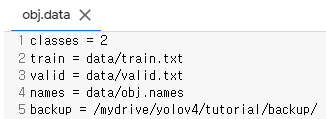

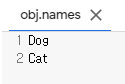

In [ ]:
%%writefile obj.data
classes = 2
train = data/train.txt
valid = data/valid.txt
names = data/obj.names
backup = /mydrive/yolov4/tutorial/backup/

Writing obj.data


In [ ]:
%%writefile obj.names
Dog
Cat

Writing obj.names


In [ ]:
!cp obj.names ./data/obj.names
!cp obj.data ./data/obj.data

### train.txt & valid.txt 만들기 

사용자 정의 함수



In [ ]:
%cd /mydrive/
from helpfunction import create_list, download, imShow
%cd /content/darknet/

/content/gdrive/MyDrive
/content/darknet


In [ ]:
!pwd

/content/darknet


In [ ]:
create_list('train')

In [ ]:
create_list('valid')

In [ ]:
!ls data/*.txt

data/goal.txt  data/train.txt  data/valid.txt


* 이제 준비 완료 - check list
1. cfg 파일
2. obj.data
3. obj.names
4. train 데이터와 valid 데이터
5. train.txt, valid.txt


## 단계 3. 시작 가중치 다운로드 받기

* train 속도를 위해서 초기 가중치 사용

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

## 단계 4. Train

```
!./darknet detector train <path to obj.data> <path to custom config> yolov4.conv.137 -dont_show -map
```

In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-tutorial.cfg yolov4.conv.137 -dont_show -map  

In [ ]:
download('chart.png')

FileNotFoundError: ignored

센셕 끊김 방지를 위해

f12 -> 실행 

```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```



```
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_last.weights -dont_show
```

In [ ]:
# 섹션이 끊겼을 경우 이어서 트레인 하는 방법
# !./darknet detector train data/obj.data cfg/yolov4-tutorial.cfg /mydrive/yolov4/tutorial/backup/yolov4-obj_last.weights -dont_show

## 단계 5. 모델 평가하기

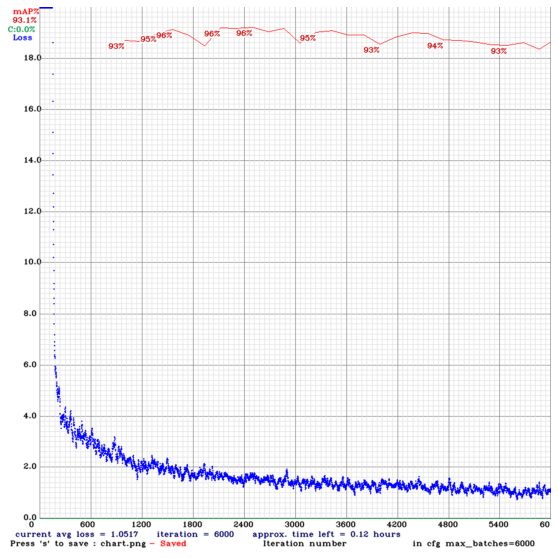

In [ ]:
imShow('chart.png')

## 단계 6. 모델 사용해 보기

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-tutorial.cfg /content/gdrive/MyDrive/yolov4/tutorial/backup/yolov4-tutorial_best.weights /mydrive/data/dog2.jpg   6+6

In [ ]:
imShow('predictions.jpg')

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov4-tutorial.cfg /content/gdrive/MyDrive/yolov4/tutorial/backup/yolov4-tutorial_best.weights -dont_show /content/gdrive/MyDrive/data/Puppies.mp4 -i 0 -out_filename results.avi

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

FPS:49.2 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 95% 
Dog: 93% 

FPS:49.0 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 94% 
Dog: 94% 

FPS:49.8 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 94% 
Dog: 94% 

FPS:50.8 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Cat: 29% 
Dog: 72% 
Dog: 92% 

FPS:51.7 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 93% 
Dog: 81% 

FPS:52.0 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 94% 
Dog: 93% 

FPS:50.9 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 92% 
Dog: 82% 

FPS:50.2 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 92% 
Dog: 91% 

FPS:49.7 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 91% 
Dog: 86% 

FPS:48.1 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 91% 
Dog: 89% 

FPS:49.5 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 96% 
Dog: 88% 

FPS:50.5 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 96% 
Dog: 91% 

FPS:51.3 	 AVG_FPS:41.8

 cvWriteFrame 
Objects:

Dog: 95% 
Dog: 91% 

FPS:51.1 	 AVG_FPS:41.8

 cvWr

In [ ]:
download('./results.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp results.avi /mydrive/data/results3.avi